# Point-wise and group-wise cross sections

In this notebook all the solutions are given, therefore you do not need to submit it. The goal is to provide a foundation for group-wise cross sections which you will build on during the later notebooks.

In the Reactor physics with Python course we have mostly used cross section data for visualization, to deduce eg. whether a nuclide is fissile. We have downloaded so-called point-wise cross sections in a tabulated format, These are continous representation of cross sections, which can be used to determine the cross section at any arbitrary value by applying a given interpolation rule. Infact we have used such data to develop simple Monte Carlo particle transport calculations. 

We have already discussed in the previous notebook that the raw nuclear data files do not contain the data in this format (mostly because it would not be practical, and would require to handle a large amount of data). The raw nuclear data is instead reconstructed (in the next datalab we will see how, for example, the resonances can be reconstructed) to obtain the point wise format from. 

It is also important to highlight however that in practice most of the reactor physics codes do not make use data in the format we used it for visualization. Although Monte Carlo codes do make use of point-wise cross sections, but the actual format has its own specifications. And for deterministic codes we need to obtain group wise cross sections, meaning that we have to calculated a weighted average of the cross section data over certain energy bounds. The weighting is done with the neutron spectrum in order to preserve the reaction rates within the energy groups.

In this datalab we are going to get familiar point-wise and group-wise cross sections, to build our foundations for the following datalabs. We are going to collapse the point-wise cross sections into group constants with an idealized neutron spectrum.

## Point-wise cross sections

In this datalab we will not yet reconstruct the raw nuclear data, instead we are going to use the tabulated point-wise cross sections of the (n,g) reaction on U-238 dowloaded from [KAERI's](https://atom.kaeri.re.kr/nuchart/) nuclide chart. The data is stored in the 'data/U238pw.dat' file and corresponds to 294K.

Let's first just inspect the content of this

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with open('data/U238pw.dat', 'r') as endf:
    print(''.join(endf.readlines()[:25]))

 U-238(n,g) ENDFB-8.0
Energy(eV) XS(b)
1.00000E-05 134.556
1.03125E-05 132.502
1.06250E-05 130.539
1.09375E-05 128.660
1.12500E-05 126.861
1.15625E-05 125.135
1.18750E-05 123.477
1.21875E-05 121.884
1.25000E-05 120.351
1.28125E-05 118.874
1.31250E-05 117.450
1.34375E-05 116.077
1.37500E-05 114.750
1.43750E-05 112.228
1.50000E-05 109.865
1.56250E-05 107.645
1.62500E-05 105.555
1.68750E-05 103.582
1.75000E-05 101.715
1.81250E-05 99.9460
1.87500E-05 98.2661
1.93750E-05 96.6682
2.00000E-05 95.1457



As we see the first two header lines contain relevant information about the nuclide, reaction and the nuclear data library the data is obtained from. Then the following values are given in Energy-Cross section pairs.

We can load the data with numpy into arrays.

In [2]:
exs,xs=np.loadtxt('data/U238pw.dat',skiprows=2).transpose()
print('There are {} values in the file.'.format(len(xs)))

There are 154426 values in the file.


The file contains more than a hundred thousand values! We can already feel why it is more practical to reduce this by storing for example only the resonance energies and widths, and reconstruct it later. One must also highlight that clearly these cross sections are given at one single temperature (294K for this case), therefore if for an application one is interested in other temperatures further processing is needed (as we will try in a later notebook).

For the moment we will just visualize this cross section...

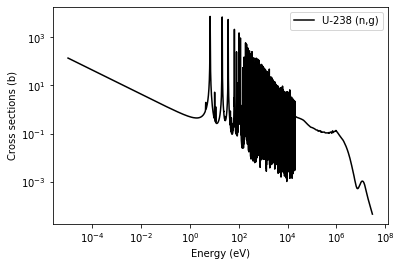

In [3]:
plt.figure()
plt.loglog(exs,xs, 'k', label='U-238 (n,g)')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross sections (b)')
plt.legend()
plt.show()

... and the notable resonance of U-238 at 6.67 eV. One can observe that several data points are needed to represent the resonance, whereas as we will see later, in the raw data it is represented by a handful of parameters only.

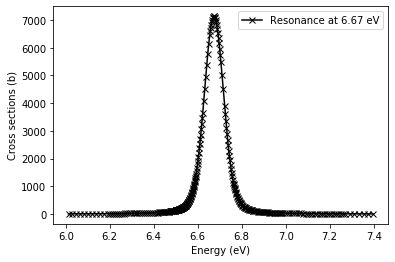

In [4]:
mask = (exs>=6.) *  (exs<=7.4)
plt.figure()
plt.plot(exs[mask],xs[mask],'kx-',label='Resonance at 6.67 eV')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross sections (b)')
plt.legend()
plt.show()


## Group-wise cross section

As discussed before, the group cross sections are the spectrum weighted average of the continuous cross sections:

$$\sigma_g=\frac{\int_{E_{g}}^{E_{g-1}}\sigma(E)\Phi(E)dE}{\int_{E_{g}}^{E_{g-1}}\Phi(E)dE}$$

Where $g$ stands for the group. Note that with introducing the group flux $\Phi_g=\int_{E_{g}}^{E_{g-1}}\Phi(E)dE$, it becomes clear that the above expression states that the reaction rate within the energy group is preserved during the collapsing.

Note that the energy dependent flux needs to be a priori known for calculating the group cross sections. That is one of the reasons why determinstic methods solve the transport problem in multiple steps. First the group-wise cross sections are prepared in couple of hundred groups with an idealized neutron spectrum with a nuclear data processing code, such as NJOY. Then, neutron transport is solved on a cell level (eg. a fuel assembly) in many groups, with the goal that a more realistic spectrum is obtained and few group group cross sections are calculated and homoganized over space as well. Finally, one would perform a full-core calculation based on the group cross sections and often on neutron diffusion theory. As we see, already for the cell level calculation one needs to provide group cross sections, which requires an assumption of the neutron spectrum. 

One should not also, that today, it is becoming common to generate group constants for full-core simulators (homoganized over the spatial domain as well) from time consuming Monte Carlo methods, however since many applications still rely on deterministic lattice calculations, it is still important to understand the fundamentals of the deterministic approach.

### The weighting spectrum

In this datalab we are going to weight with an idealized neutron spectrum, which consists of a Maxwellian spectrum at low energies, a 1/E spectrum at epithermal energies and a Watt spectrum at fast energies:

- Thermal component described by Maxwellien

$$f_{th}(E)=\alpha_{th}E\exp\big(-\frac{E}{kT}\big)$$

where $\alpha_{th}$ is a normalization constant, $k$ is the Boltzmann-constant, $T$ is the thermodynamical temperature (in K) and $E$ is the energy (in eV).

- Epithermal component Described by $1/E$ as a piecewise function to account for the thermal and fast limit values:

\begin{equation}
    f_{epi}(E) = 
    \begin{cases}
      \alpha_{epi}\frac{E^2-E_0^2}{E(E_1^2-E_0^2)} & \text{if $E_0\leq E \leq E_1$} \\
      \alpha_{epi}\frac{1}{E} & \text{if $E_1\leq E \leq E_2$} \\
      \alpha_{epi}\frac{E^2-E_3^2}{E(E_2^2-E_3^2)} & \text{if $E_2\leq E \leq E_3$} \\
      0 & \text{else}
    \end{cases}
\end{equation}

Where $\alpha_{epi}$ is a normalization constant, and the energy limits are chosen to be $E_0=0 eV$, $E_1=0.2 eV$ $E_2=0.25 eV$ and $E_3=1 MeV$

- Fast component described by the Watt fission spectrum

$$f_{fast}(E)=\alpha_{fast}\exp\big(-\frac{E}{a}\big)\sinh(\sqrt{bE})$$

where $\alpha_{fast}$ is a normalization constant and for U-235 the parameters are $a=9.65\cdot 10^5 eV$ and $b=2.29\cdot 10^{-6} eV^{-1}$. But in the example we will use slightly different values (since the fission does not happen only in U-235).

The normalization is done so that $\int_0^\infty f_{th}(E)dE=\int_0^\infty f_{epi}(E)dE=\int_0^\infty f_{fast}(E)dE=1$.

- Finally the spectrum will be a sum of these components whit some appropriate flux values:

$$\Phi(E) = \Phi_{th}f_{th}(E) + \Phi_{epi}f_{epi}(E) + \Phi_{fast}f_{fast}(E)$$.

For the sake of visualizing the spectrum the following constants are selected which are representated to the [BR2 reactor in Mol](https://www.sciencedirect.com/science/article/pii/S016890020800795X).

- $\Phi_{th} = 3.2\cdot 10^{14}$ ncm$^{-2}$s$^{-1}$
- $\Phi_{epi} = 1.98\cdot 10^{14}$ ncm$^{-2}$s$^{-1}$
- $\Phi_{fast} = 0.98\cdot 10^{14}$ ncm$^{-2}$s$^{-1}$
- $T=325$ K
- $a=8.09\cdot 10^5$ eV
- $b=9.32\cdot 10^{-7}$ eV$^{-1}$

The weakness of this model is that the dips in the 1/E region due to energy self-shielding effect of the cross section resonances are not present. In a later notebook we will further investigate the consequence of this ignorance, and possible approximations to remedy it. Nevertheless already now it can be mentioned that this model represents an infinitly dilute material, meaning that the resonant nuclei (eg. U-238) is dilutated by a non-resonant material (eg. water) so that the probability of a neutron captured by the resonant nuclei is zero. Don't worry, we are going to discuss dilution later on!

Let's just execute now the cell below to define a function which implements the above discussed model.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def getSpectrum(energy,T=325,PhiTh=3.2e14,PhiEpi=1.98e14,PhiFast=0.98e14):
    """Approximating the spectrum as in NIMA Vol 593 pp510-518 paper. 
    Constants describing the flux are taken from the same paper"""
    #thermal
    fth=[]
    k=8.6173324e-5 #eV/K
    for E in energy:
        fth.append(E*np.exp(-E/(k*T)))   #who needs pythonic way?
    energy=np.array(energy)
    fth=np.array(fth)
    fth=fth/np.trapz(fth,energy) #normalize
    
    #epithermal
    fepi=[]
    E0=0
    E1=0.2
    E2=0.25e6
    E3=1e6
    for E in energy:
        if E0<=E and E<E1:
            fepi.append((E**2-E0**2)/(E*(E1**2-E0**2)))
        elif E1<=E and E<E2:
            fepi.append(1/E)
        elif E2<=E and E<E3:
            fepi.append((E**2-E3**2)/(E*(E2**2-E3**2)))
        else:
            fepi.append(0.0)
    fepi=np.array(fepi)
    fepi=fepi/np.trapz(fepi,energy)
    
    #fast
    ffast=[]
    a=8.09e5 #u235 9.65e5
    b=9.32e-7 #u235 2.29e-6
    for E in energy:
        ffast.append(np.exp(-E/a)*np.sinh(np.sqrt(b*E)))
    ffast=np.array(ffast)
    ffast=ffast/np.trapz(ffast,energy)
    
    #create real spectrum
    
    phi=PhiTh*fth+PhiEpi*fepi+PhiFast*ffast
                                                    #one could return all the components separately to
    return phi#,PhiTh*fth,PhiEpi*fepi,PhiFast*ffast #for visualization, but here we just return the spectrum

Then we can create a spectrum at the energy values where the cross section is given.

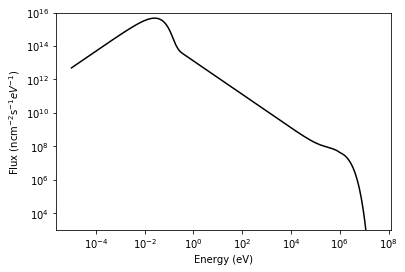

In [6]:
spectrum=getSpectrum(exs,T=295)
plt.figure()
plt.loglog(exs,spectrum,'k')
plt.ylim([1e3,1e16])
plt.xlabel('Energy (eV)')
plt.ylabel(r'Flux (ncm$^{-2}$s$^{-1}eV^{-1}$)')
plt.show()

### The energy group structure

Of course we do need to define an energy group structure. The simplest would be to integrate between 0 and $\infty$ and then one could gain one group cross sections.

So how to define a group structure? Well, it depends on your application. You can find a nice review of energy structures at [LANL T2](https://t2.lanl.gov/nis/njoy/grou03.html). Here we just highlight the key takeaway. You might remember that reactor physicists often prefer to use the lethargy instead of the energy:

$$u=\ln \frac{E_0}{E}$$

$$E=E_0e^{-u}$$

where $E_0$ is some appropriately chosen highest energy value, for reactor application this is usually chosen to be between 10-20 MeV (you might see different values in various textbooks).

During slowing down the lethargy increases (the neutron becomes more and more lethargic). If you select your energy group with equal lethargy width in the slowing down region (ie. where the spectrum has a 1/E shape) then each group contains the same portion of the flux. You also might remember that in elastic scattering the the average lethargy change is constant. Thus, most energy group stuctures have equal lethargy width. However, some lethargy regions may contain more groups in order to center resonances. If you know beforehand which nuclides are of interest for you, you might want to use a group structure which covers the resonances of the nuclides. 

For this notebook we will use the LANL 187-group structure which is suitable for thermal reactor applications.

You can find the lower and upper energy bounds of this structure in the 'data/lanl187.txt' file.

Let's visualize the group structure. First, just illustrate the lower boundaries of the energy bins on a logarithmic scale.

In [7]:
ind,elow,ehigh=np.loadtxt('data/lanl187.txt').transpose()

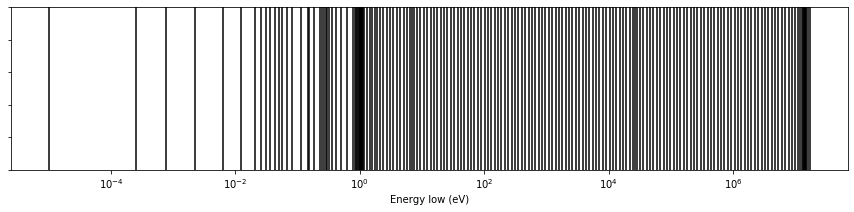

In [8]:
plt.figure(figsize=(15,3))
for el in elow:
    plt.axvline(el,color='k')
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
plt.xscale('log')
plt.xlabel('Energy low (eV)')
plt.show()

We can get further ideas on how to illustrate energy groups for example [here](https://fispact.ukaea.uk/development/self-shielding/). We could plot the incident energy (let's define it as the midpoint of the energy bins) agains the cumulative number of the groups or against the width of the energy bin. Let's do that.

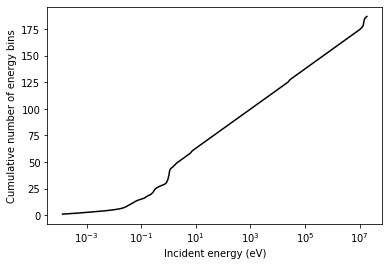

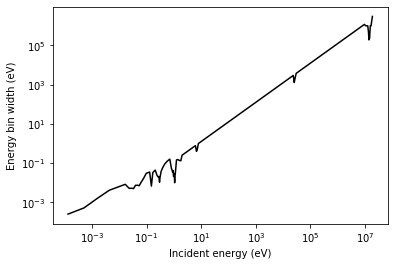

In [9]:
ebinw=[eh-el for el,eh in zip(elow,ehigh)]        #the width of the energy bins
ebinc=[(eh+el)/2 for el,eh in zip(elow,ehigh)]    #the midpoint of the energy bins

#Cumulative number of energy bins
plt.figure()
plt.semilogx(ebinc, range(1,len(ebinc)+1),'k')
plt.xlabel('Incident energy (eV)')
plt.ylabel('Cumulative number of energy bins')
plt.show()

#Energy bin width vs incident energy
plt.figure()
plt.loglog(ebinc,ebinw,'k-')
plt.xlabel('Incident energy (eV)')
plt.ylabel('Energy bin width (eV)')
plt.show()

Often it is of interest to visualize the group structure in lethargy variables. We will repeat the first and the previous figure for lethargy variables to illustrate the lethargy bin width versus incident energy. What would be your choice for $E_0$ for this structure?

Note that the lethargy increases as the energy decreases. Therefore the lower energy boundaries become the higher lethargy boundaries for the bins.

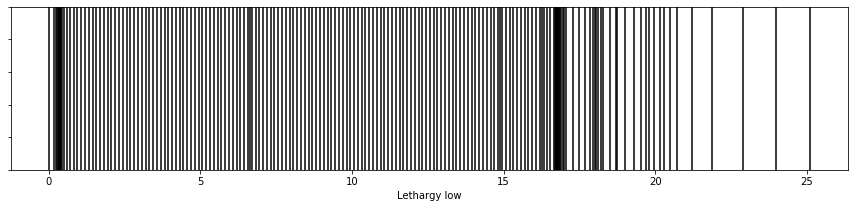

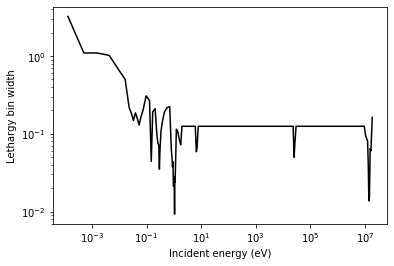

0.00926808222943265


In [10]:
uhigh=[np.log(ehigh[-1]/el) for el in elow]
ulow=[np.log(ehigh[-1]/eh) for eh in ehigh]
ubinw=[uh-ul for ul,uh in zip(ulow,uhigh)]

plt.figure(figsize=(15,3))
for ul in ulow:
    plt.axvline(ul,color='k')
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
plt.xscale('linear')
plt.xlabel('Lethargy low')
plt.show()

plt.figure()
plt.loglog(ebinc,ubinw,'k-')
plt.xlabel('Incident energy (eV)')
plt.ylabel('Lethargy bin width')
plt.show()

print(min(ubinw))

### Weighting the cross sections

And now we can go ahead and perform the weighting. We are going to use `np.trapz` to perform the integration, but it can be highlighted that more elaborate methods could be used.

In [11]:
grpxs=[]
for el,eh in zip(elow,ehigh):
    Egrid=np.linspace(el,eh,1000)                 #divide the energy group into 1000 values      
    Phigrid=np.interp(Egrid,exs,spectrum)         #evaluate the spectrum at these values
    XSgrid=np.interp(Egrid,exs,xs)                #determine the point-wise xs at these values
    grpxs.append(np.trapz(XSgrid*Phigrid,Egrid)/np.trapz(Phigrid,Egrid))

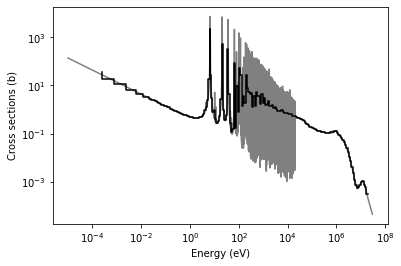

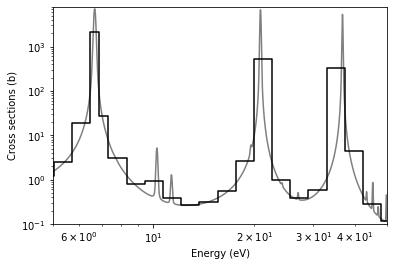

In [12]:
plt.figure()
plt.loglog(exs,xs,'gray')
plt.step(ehigh,grpxs,'k')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross sections (b)')
plt.show()

plt.figure()
plt.loglog(exs,xs,'gray')
plt.step(ehigh,grpxs,'k')
plt.xlim(5,50)
plt.ylim(0.1,8000)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross sections (b)')
plt.show()


### Scattering matrix

There are certain reactions however which are described by differential cross sections, such as elastic scattering. The multigroup constants of such reactions become group-transfer cross sections in the form of matrices. For example the differential cross section $\sigma(E'\rightarrow E)$ is substituted with $\sigma_{g'\rightarrow g}$ (or often noted only with $\sigma_{g'g}$) with the following definition (see for example p289 of [D&H](https://deepblue.lib.umich.edu/handle/2027.42/89079))

$$\sigma_{g'\rightarrow g}=\frac{\int_gdE\int_{g'}dE'\sigma_s(E'\rightarrow E)\phi(E')}{\int_{g'}\phi(E)dE}$$

We are going to evaluate this for a simple case: let us consider that there is only elastic scattering, isotropic in the Center-of-mass frame at any energies, thus the differential cross section is given by

\begin{equation}
    \sigma_s(E'\rightarrow E) = 
    \begin{cases}
      \frac{\sigma_s(E')}{(1-\alpha)E'} & \text{if} \: \alpha E' \leq E \leq E' \\
      0 & \text{otherwise}
    \end{cases}
\end{equation}

As we will see later, at high energies, scattering becomes anisotropic in the CM frame, and at thermal energies, one needs to take into account the chemical bonds between atoms (if the scatterrer is not made of free atoms), and the movement of the atoms due to temperature. For the moment, we will ignore these effects, since our goal is just to demonstrate the scattering transfer matrix.

We have downloaded the scattering cross section $\sigma_s(E)$ for H-1. It can be found in ´data/H1pw.dat´. We will use these values for the cross section, even for cases when we try different $\alpha$ values in the scattering kernel. 

Let's define functions `phi()` and `sigma()` which are simply wrappers for `np.interp`. Also define `collapseScatter()` which is a very simple numerical representation of the integrals in the definition of $\sigma_{g'\rightarrow g}$. The input parameters are the lower and upper bounds of group $g'$ and $g$.

In [13]:
exsh,xsh=np.loadtxt('data/H1pw.dat',skiprows=2).transpose()

def phi(E):                          #note we use our previous exs and spectrum values
    return np.interp(E,exs,spectrum) #because they contain more energies than exsh
def sigma(E):
    return np.interp(E,exsh,xsh)

def collapseScatter(elp,ehp,el,eh,N=10):
    """
    Function to evaluate the g'->g element of the scattering matrix
    
    Parameters
    ----------
    elp : float
        lower energy bound of group g'
    ehp : float
        higher energy bound of group g'
    el : float
        lower energy bound of group g
    eh : float
        higher energy bound of group g
    N : int
        Number of subdivisions for the groups (influences the accuracy of the numerical integration).
    
    Notes
    -----
    1. The algorithm is not super efficient, but is easy to follow. Note that due to the less than equal in
    `alpha*Ep<=E and E<=Ep`, if g'=g-1 the return value is non-zero (appears as upscattering), but this is
    only a numerical issue. With increasing N the return value converges to zero. Any how, here we do intend
    to call the function only for g'>g
    2. Variable alpha, and functions phi() and sigma() are not defined in the local scope, 
    python will look for them globally.
    """
    Egridp=np.linspace(elp,ehp,N)
    Egrid=np.linspace(el,eh,N)
    outer=[]
    for E in Egrid:
        inner=[]
        for Ep in Egridp:
            if alpha*Ep<=E and E<=Ep:
                inner.append(sigma(Ep)/(1-alpha)/Ep*phi(Ep)) 
            else:
                inner.append(0.0)
        outer.append(np.trapz(inner,Egridp))
    return np.trapz(outer,Egrid)/np.trapz(phi(Egridp),Egridp)

Now we will evaluate the the group constant for all the combinations of $g'$ and $g$ which represent downscattering (we know that in our simple approximation there is no upscattering). Note that our group numbering increases for increasing energies, whereas in practice it is more common to index the other way around, by representing the highest energy group with index $0$.

Since our integration is not the most efficient, the code below takes a while to execute.

In [14]:
A=1
alpha=(A-1)**2/(A+1)**2

sigma_gpg=np.zeros((len(ind),len(ind)))
for i in range(len(ind)):
    for j in range(len(ind)):
        elp=elow[i]
        ehp=ehigh[i]
        el=elow[j]
        eh=ehigh[j]
        if i>=j:
            sigma_gpg[i,j]=collapseScatter(elp,ehp,el,eh)

Let's visualize now the transfer matrix. We will use `plt.imshow()` for this.

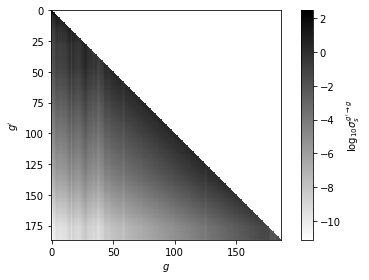

In [15]:
plt.figure()
np.seterr(divide='ignore') #np.log10 is applied on a matrix with many 0.0 values, we disable the warning
plt.imshow(np.log10(sigma_gpg),'gray_r')
cbar=plt.colorbar()
cbar.set_label(r"$\log_{10}\sigma_{s}^{g'\rightarrow g}$")
plt.ylabel(r"$g'$")
plt.xlabel("$g$")
plt.tight_layout()
plt.show()

We can observe that the lower triangle of the matrix is non zero. This is expected since elastic scattering on Hydrogen can bring a neutron from any energy to any lower energy. We see that the transfer matrix seems to have some structure, but this is a result of the group structure.

Now, you can try to modify the mass number `A`, and therefore `alpha`. Try for example `A=2` and `A=12`. You do not need to download the scattering cross section for Deuterium and for Carbon, since the shape of the cross section for those is rather similar as for Hydrogen (and we don't care for this demonstration about the absolue values being correct). What is your expectation, how will the transfer matrix look like? Write down your conclusions.